In [1]:
import timm
import random
import numpy as np
import torch
from torch import nn, optim, quantization
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAUROC, MulticlassROC
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# Constants

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
EPOCHS = 50
RANDOM_SEED = 44

data_dir = '/kaggle/input/liver-histopathology-fibrosis-ultrasound-images/Dataset/Dataset'
stats_dir = '/kaggle/input/stats-liver/stats_liver (1).csv'
generator = torch.Generator().manual_seed(RANDOM_SEED)

df = pd.read_csv(stats_dir)
MEAN = list(df['Mean'])
STD = list(df['Standard Deviation'])

print(f'Mean: {MEAN}\nSTD: {STD}')

TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

Mean: [0.083514534, 0.083514534, 0.083514534]
STD: [0.13147554, 0.13147554, 0.13147554]


In [3]:
# Seed environment

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Data

dataset = datasets.ImageFolder(data_dir, transform=TRANSFORMS)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
print(f'Train: {len(train_set)}\nVal:{len(val_set)}\nTest: {len(test_set)}')

Train: 5059
Val:632
Test: 632


In [5]:
# Modules

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "hf_hub:timm/vit_base_patch16_224.augreg2_in21k_ft_in1k",
            features_only=True,
            pretrained=False
        )

    def forward(self, x):
        feats = self.backbone(x)[-1]
        return feats

class ProjectionHead(nn.Module):
    def __init__(self, in_dim=768):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_dim, 384),
            nn.BatchNorm1d(384),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.head(x)

class Classifier(nn.Module):
    def __init__(self, in_dim=192):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_dim, 96),
            nn.BatchNorm1d(96),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(96, 5),
            nn.BatchNorm1d(5),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        return self.head(x)

In [6]:
enc_sup = Encoder().to(device)
enc_sup.load_state_dict(torch.load('/kaggle/input/encoder-supervised/pytorch/default/1/best_encoder_supervised.pth'))
proj_sup = ProjectionHead().to(device)
proj_sup.load_state_dict(torch.load('/kaggle/input/projection-supervised/pytorch/default/1/best_proj_head_supervised.pth'))
class_sup = Classifier().to(device)
class_sup.load_state_dict(torch.load('/kaggle/input/classifier-supervised/pytorch/default/1/best_classifier_supervised.pth'))

enc_con = Encoder().to(device)
enc_con.load_state_dict(torch.load('/kaggle/input/encoder-contrastive/pytorch/default/1/best_encoder_con_classification.pth'))
proj_con = ProjectionHead().to(device)
proj_con.load_state_dict(torch.load('/kaggle/input/projection-contrastive/pytorch/default/1/best_proj_head_con_classification.pth'))
class_con = Classifier().to(device)
class_con.load_state_dict(torch.load('/kaggle/input/classifier-contrastive/pytorch/default/1/best_classifier_con.pth'))

config.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

<All keys matched successfully>

In [7]:
def test(encoder, proj_head, classifier, loader, model_type, bits=32):
    encoder.eval()
    proj_head.eval()
    classifier.eval()
    device = torch.device('cpu' if bits == 8 else 'cuda')
    acc = MulticlassAccuracy(num_classes=5, average='weighted').to(device)
    prec = MulticlassPrecision(num_classes=5, average='weighted').to(device)
    rec = MulticlassRecall(num_classes=5, average='weighted').to(device)
    f1 = MulticlassF1Score(num_classes=5, average='weighted').to(device)
    auroc = MulticlassAUROC(num_classes=5, average=None).to(device)
    roc = MulticlassROC(num_classes=5).to(device)
    all_probs, all_labels = [], []
    with torch.inference_mode():
        for images, labels in tqdm(loader, desc=f"Testing {model_type}"):
            images, labels = images.to(device), labels.to(device)
            if bits == 16:
                images = images.half()
            enc = torch.mean(encoder(images), dim=(2, 3))
            feats = proj_head(enc)
            logits = classifier(feats)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            acc.update(preds, labels)
            prec.update(preds, labels)
            rec.update(preds, labels)
            f1.update(preds, labels)
            auroc.update(probs, labels)
            all_probs.append(probs.cpu())
            all_labels.append(labels.cpu())
    all_probs = torch.cat(all_probs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    fpr, tpr, _ = roc(all_probs, all_labels)
    auroc_vals = auroc.compute().cpu().numpy()
    metrics = {
        "Accuracy": acc.compute().item(),
        "Precision": prec.compute().item(),
        "Recall": rec.compute().item(),
        "F1 Score": f1.compute().item(),
        "Mean AUROC": auroc_vals.mean().item()
    }
    for i, val in enumerate(auroc_vals):
        metrics[f"AUROC_Class_F{i}"] = float(val)
    df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
    df.to_csv(model_type + '_metrics.csv', index=False)
    plt.figure(figsize=(12, 10))
    for i in range(len(fpr)):
        plt.plot(fpr[i], tpr[i], label=f"Class F{i} (AUROC={auroc_vals[i]:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_type}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{model_type}_ROC.pdf", dpi=600)
    plt.show()
    return metrics

Testing Supervised: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


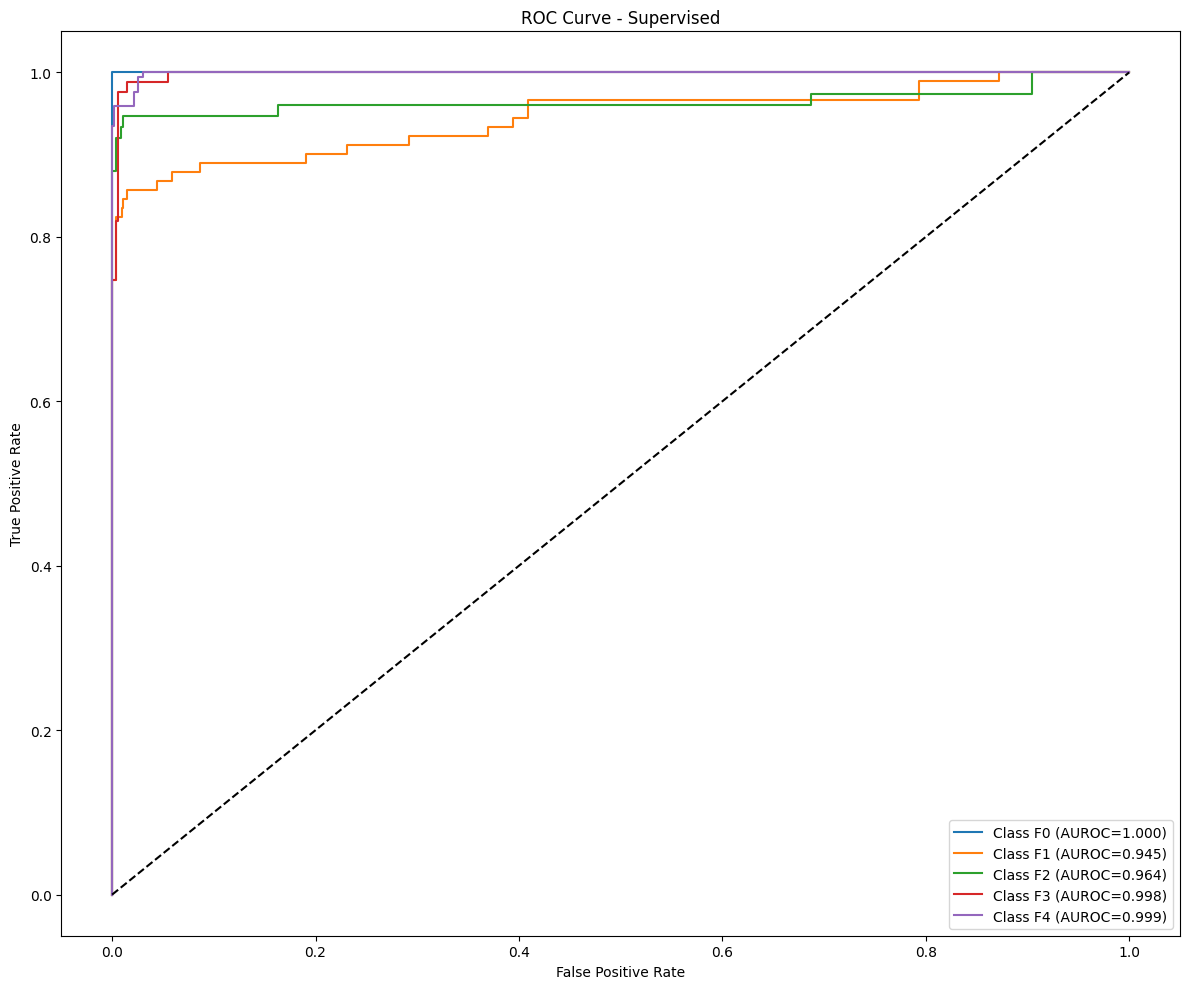

{'Accuracy': 0.9272152781486511, 'Precision': 0.9422663450241089, 'Recall': 0.9272152781486511, 'F1 Score': 0.9298118948936462, 'Mean AUROC': 0.9812210202217102, 'AUROC_Class_F0': 1.0, 'AUROC_Class_F1': 0.9450143575668335, 'AUROC_Class_F2': 0.9641172885894775, 'AUROC_Class_F3': 0.998046875, 'AUROC_Class_F4': 0.9989264607429504}


Testing Contrastive: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


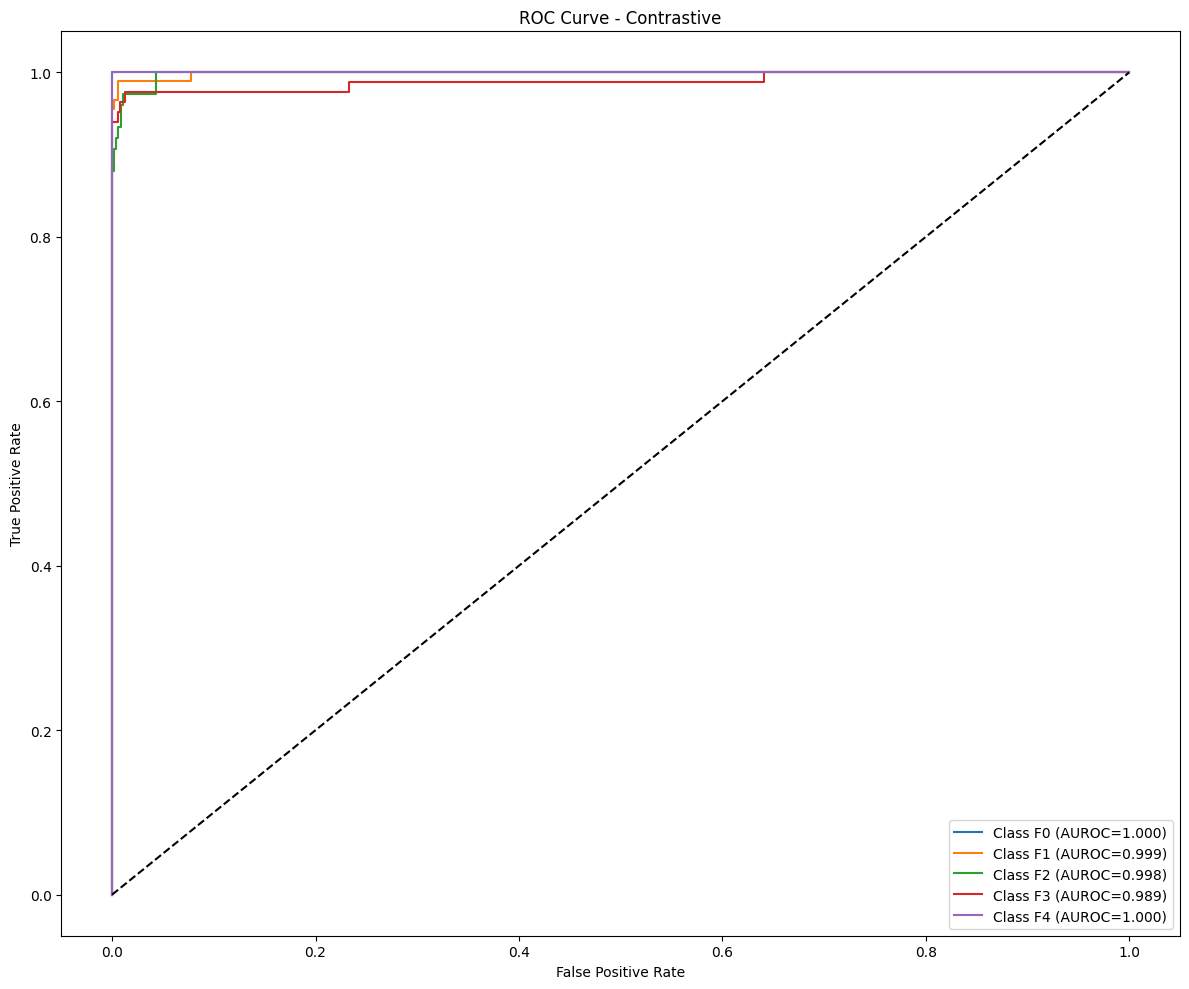

{'Accuracy': 0.9810127019882202, 'Precision': 0.9810127019882202, 'Recall': 0.9810127019882202, 'F1 Score': 0.9810127019882202, 'Mean AUROC': 0.9972928166389465, 'AUROC_Class_F0': 1.0, 'AUROC_Class_F1': 0.9990047216415405, 'AUROC_Class_F2': 0.9983004331588745, 'AUROC_Class_F3': 0.9891588687896729, 'AUROC_Class_F4': 1.0}


In [8]:
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=3, pin_memory=True, shuffle=False)

print(test(enc_sup, proj_sup, class_sup, test_loader, 'Supervised'))
print(test(enc_con, proj_con, class_con, test_loader, 'Contrastive'))

In [9]:
def quantize_models(enc, proj, clas, bits=16):
    if bits == 16:
        enc = enc.half()
        proj = proj.half()
        clas = clas.half()
    else:
        enc = torch.ao.quantization.quantize_dynamic(
            enc.cpu(),
            {nn.Linear, nn.LayerNorm, nn.Conv2d},
            dtype=torch.qint8
        )
        proj = torch.ao.quantization.quantize_dynamic(
            proj.cpu(),
            {nn.Linear, nn.BatchNorm1d},
            dtype=torch.qint8
        )
        clas = torch.ao.quantization.quantize_dynamic(
            clas.cpu(),
            {nn.Linear, nn.BatchNorm1d},
            dtype=torch.qint8
        )
    return enc, proj, clas

Testing Supervised - 16 bit: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


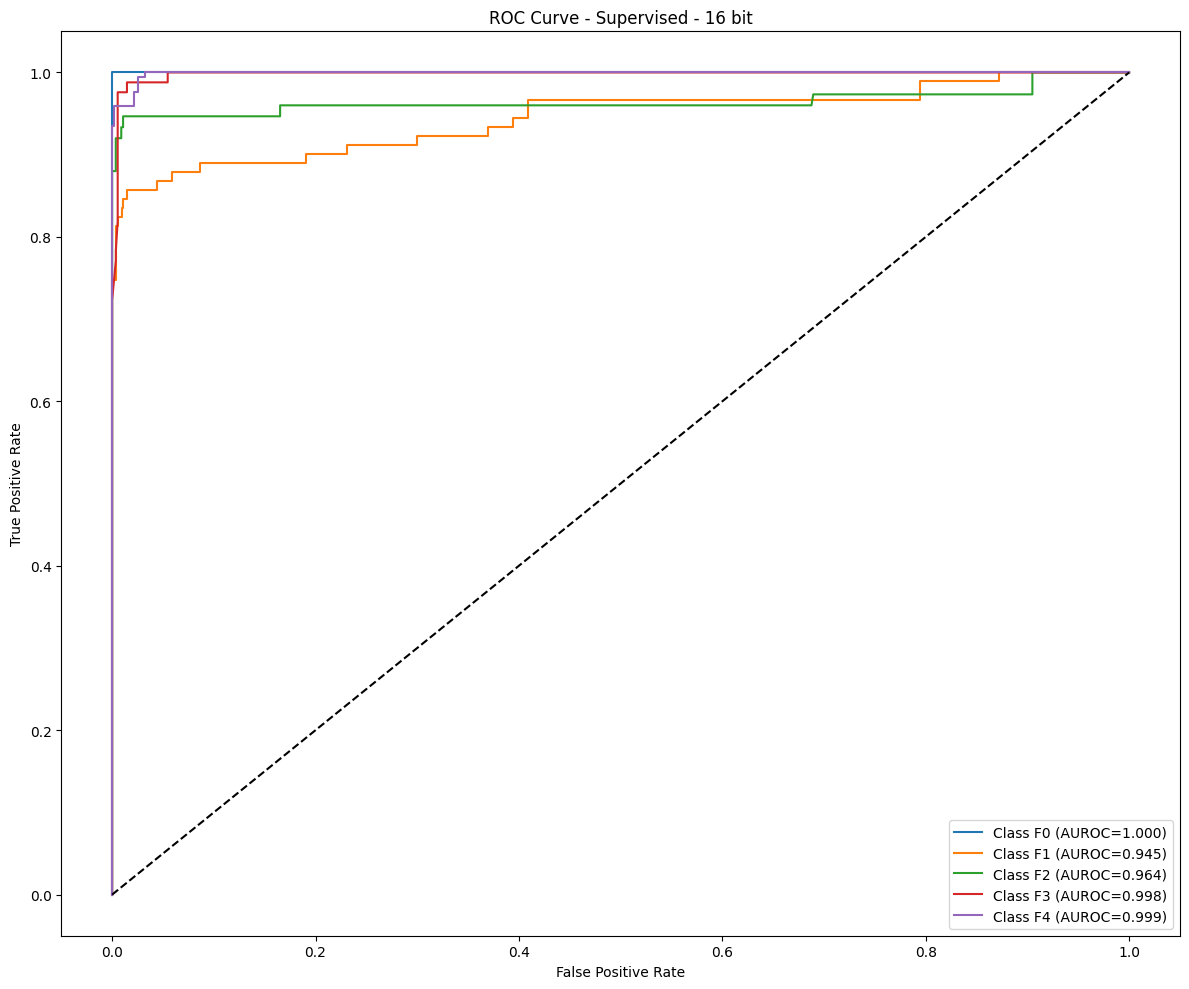

{'Accuracy': 0.9272152781486511, 'Precision': 0.9422663450241089, 'Recall': 0.9272152781486511, 'F1 Score': 0.9298118948936462, 'Mean AUROC': 0.9811762571334839, 'AUROC_Class_F0': 1.0, 'AUROC_Class_F1': 0.9448721408843994, 'AUROC_Class_F2': 0.9640814661979675, 'AUROC_Class_F3': 0.9980139136314392, 'AUROC_Class_F4': 0.9989136457443237}


Testing Contrastive - 16 bit: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


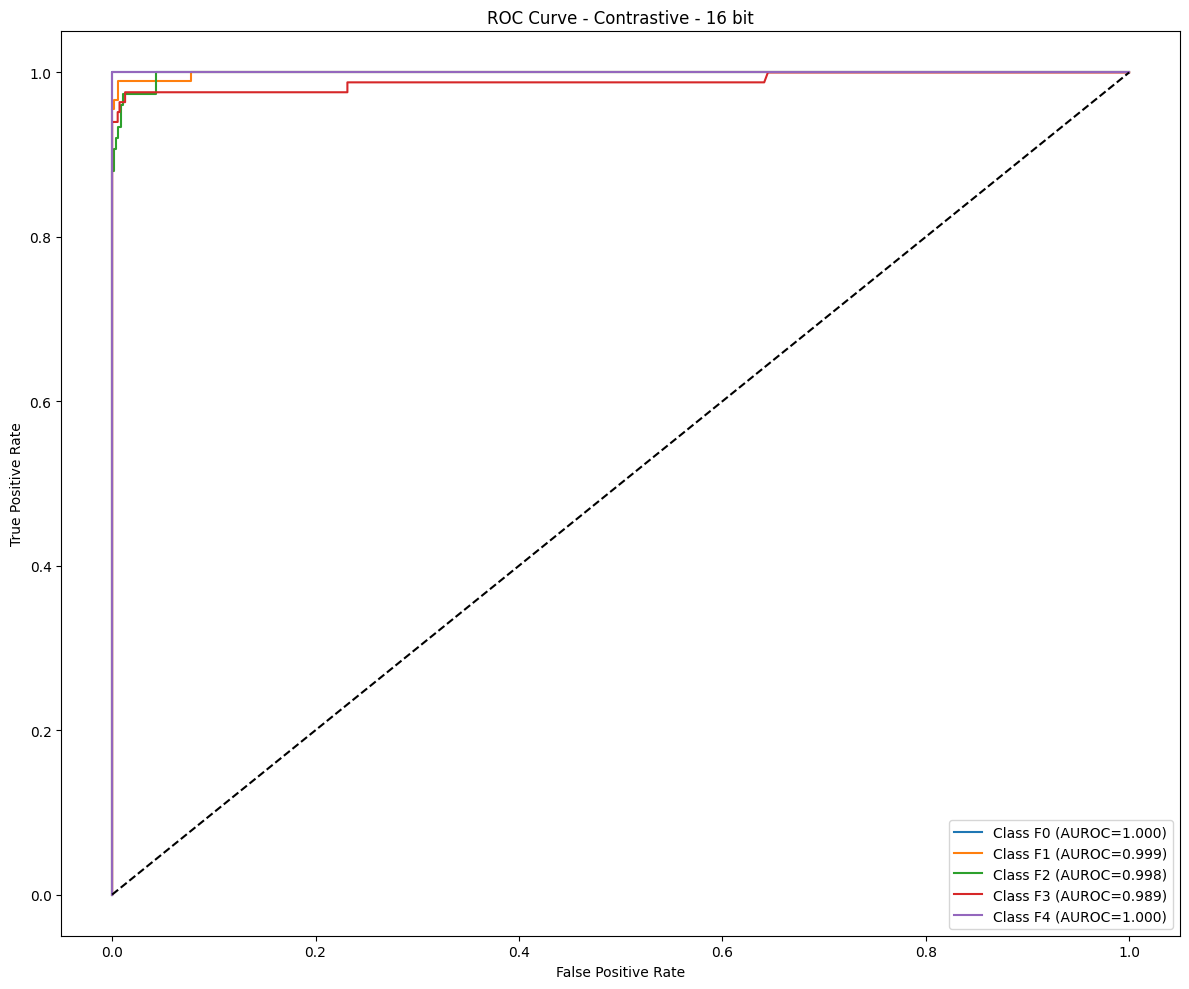

{'Accuracy': 0.9810127019882202, 'Precision': 0.9810127019882202, 'Recall': 0.9810127019882202, 'F1 Score': 0.9810127019882202, 'Mean AUROC': 0.997292697429657, 'AUROC_Class_F0': 1.0, 'AUROC_Class_F1': 0.9990046620368958, 'AUROC_Class_F2': 0.998300313949585, 'AUROC_Class_F3': 0.9891588687896729, 'AUROC_Class_F4': 1.0}


In [10]:
# Quantized

precs = [16]
for prec in precs:
    enc_sup_quantized, proj_sup_quantized, class_sup_quantized = quantize_models(enc_sup, proj_sup, class_sup, bits=prec)
    print(test(enc_sup_quantized, proj_sup_quantized, class_sup_quantized, test_loader, f'Supervised - {prec} bit', prec))
    torch.save(enc_sup_quantized, f'vit_encoder_sup_{prec}.pth')
    torch.save(proj_sup_quantized, f'proj_sup_{prec}.pth')
    torch.save(class_sup_quantized, f'class_sup_{prec}.pth')
    
    enc_con_quantized, proj_con_quantized, class_con_quantized = quantize_models(enc_con, proj_con, class_con, bits=prec)
    print(test(enc_con_quantized, proj_con_quantized, class_con_quantized, test_loader, f'Contrastive - {prec} bit', prec))
    torch.save(enc_con_quantized, f'vit_encoder_con_{prec}.pth')
    torch.save(proj_con_quantized, f'proj_con_{prec}.pth')
    torch.save(class_con_quantized, f'class_con_{prec}.pth')